# Convolutional Neural Network - Model Evaluation
Loading an existing CNN model and weights for evaluation

In [1]:
from __future__ import print_function
import pandas as pd
import os
import numpy as np
import nibabel as nib
import sys
import math
import random
import csv
import nipy
import seaborn as sns

from lifelines.utils import concordance_index

from scipy import ndimage as nd
import scipy.stats as stats
#import statsmodels.api as sm
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from pandas.tools.plotting import table
%matplotlib inline

# sys.path=[i for i in sys.path if 'local' not in i]
# sys.path.append( "/home/gennadyr/.local/lib/python2.7/site-packages")
#import tensorflow
# sys.path=[i for i in sys.path if 'local' not in i]
# sys.path.insert(0, "/home/gennadyr/.local/lib/python2.7/site-packages")

# Tensorflow 1.15 best for calculations
# Need tensorflow 2.0 for model
# Need tensorflow 1.12 for gradient calc

# maybe fix

import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)
from tensorflow.python.framework import ops

# -------------------  start importing keras module ---------------------
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Activation, Flatten, Masking# Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import CustomObjectScope
tf.compat.v1.disable_eager_execution()

#from vis.backprop_modifiers import guided

#sys.path.insert(0, "/home/gennadyr/.local/lib/python2.7/site-packages")
import h5py

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

2025-09-01 05:42:21.241611: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1


# Global variables

In [2]:
#folder locations
DATASET_DIR = '/data/scratch/jyu/DeepSurvival/data/'
#IMAGE_DIR = '/data/scratch/jyu/VBM_FS6/'
IMAGE_DIR = '/data/scratch/jyu/VBM/'
ADNI_DIR = '/data/scratch/jyu/DeepSurvival/data/ADNI/'
MASK_DIR = '/data/scratch/jyu/DeepSurvival/data/standards/'
MODEL_DIR = '/trinity/home/jyu/DeepSurvival/models/'

patients_df = []
crop_indeces = None

# Classes

### Load data

In [3]:
class LoadedHistory:
    def __init__(self, name):
        history_file = 'history_'+name+'.h5'
        
        f = h5py.File(MODEL_DIR+history_file, 'r')
        
        self.batch_losses = f['batch_losses'][:]
        self.batch_mae = f['batch_mae'][:]
        self.batch_mse = f['batch_mse'][:]

        self.batch_losses = f['epoch_losses'][:]
        self.epoch_mae = f['epoch_mae'][:]
        self.epoch_mse = f['epoch_mse'][:]

        self.score = f["score"][:]

        self.train_set = f['train_set'][:]
        self.validation_set = f['validation_set'][:]
        self.test_set = f['test_set'][:]

        self.train_distr = f['train_distr'][:]
        self.validation_distr = f['validation_distr'][:]
        self.test_distr = f['test_distr'][:]
        
        f.close()
        
        print('Loaded history from '+MODEL_DIR+history_file)


In [4]:
class LoadedDatasets:
    def __init__(self, name):
        dataset_file = 'dataset_'+name+'.h5'
        
        f = h5py.File(MODEL_DIR+dataset_file, 'r')
        
        self.train_set = f['train_set'][:]
        self.validation_set = f['validation_set'][:]
        self.test_set = f['test_set'][:]

        self.train_distr = f['train_distr'][:]
        self.validation_distr = f['validation_distr'][:]
        self.test_distr = f['test_distr'][:]
        
        f.close()

        print('Loaded datasets from '+MODEL_DIR+dataset_file)


In [5]:
class LoadData:
    """
    Loading preprocessed data from .h5 file.
    Has to be similar to saving data function in data processing notebook.
    (Same names for datasets etc.)
    
    """
    def __init__(self, name):
        dataset_file = name+'.h5'
        
        f = h5py.File(DATASET_DIR+dataset_file, 'r')
#         f = h5py.File('/home/gennadyr/IPython/tests_john/version_age_3/models/'+dataset_file, 'r')
        
        self.fraction_train = f['fraction_train'][:]
        self.fraction_validation = f['fraction_validation'][:]
        self.fraction_test = f['fraction_test'][:]

        self.train_MRI_data = f['train_MRI_data'][:]
        self.validation_MRI_data = f['validation_MRI_data'][:]
        self.test_MRI_data = f['test_MRI_data'][:]
        
        gene_columns = f['gene_column_names'][:]
        
        train_gene_data = f['train_gene_data'][:]
        validation_gene_data = f['validation_gene_data'][:]
        test_gene_data = f['test_gene_data'][:]
        
        self.train_gene_data = pd.DataFrame(train_gene_data, columns=gene_columns)
        self.validation_gene_data = pd.DataFrame(validation_gene_data, columns=gene_columns)
        self.test_gene_data = pd.DataFrame(test_gene_data, columns=gene_columns)
        
        train_label_data1 = f['train_label_data1'][:]
        train_label_data2 = f['train_label_data2'][:]
        validation_label_data1 = f['validation_label_data1'][:]
        validation_label_data2 = f['validation_label_data2'][:]
        test_label_data1 = f['test_label_data1'][:]
        test_label_data2 = f['test_label_data2'][:]
        
        columns = f['label_column_names'][:]
        
        train_label_data2 = pd.DataFrame(train_label_data2)
        train_label_data2.columns = columns
        validation_label_data2 = pd.DataFrame(validation_label_data2)
        validation_label_data2.columns = columns
        test_label_data2 = pd.DataFrame(test_label_data2)
        test_label_data2.columns = columns
        
        train_label_data2['bigrfullname'] = train_label_data1
        validation_label_data2['bigrfullname'] = validation_label_data1
        test_label_data2['bigrfullname'] = test_label_data1

        self.train_label_data = train_label_data2
        self.validation_label_data = validation_label_data2
        self.test_label_data = test_label_data2

        f.close()

        print('Loaded datasets from '+DATASET_DIR+dataset_file)

# Functions

In [6]:
# function to normalize a tensor by its L2 norm
def normalize(x):
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

### initializing

In [7]:
#initializes and set up the list of patients (global)
def init_preprocessing(filename):
    global patients_df
    patients_df = pd.read_csv(MODEL_DIR+filename+'_df.csv', index_col=0)
    
    print('Total size of dataset: {}'.format(patients_df.shape[0]))

### CNN image processing by batches

In [8]:
def generate_riskset(event_times):
    """
    Generates the riskset for every individual. Riskset is the set of individuals that have a 
    longer event time and are thus at risk of experiencing the event : Tj>=Ti
    
    Input:
    - label_data = dataframe with file name, event times and other labels that do not get used
    
    Output:
    - riskset = square matrix in which row i is the riskset of individual i compared to all 
    individuals j. Entry is true if Tj>=Ti, so individual j is 'at risk'.
    """

    o = np.argsort(-event_times, kind="mergesort")
    n_samples = len(event_times)
    risk_set = np.zeros((n_samples, n_samples), dtype=np.bool_)
    for i_org, i_sort in enumerate(o):
        ti = event_times[i_sort]
        k = i_org
        while k < n_samples and ti == event_times[o[k]]:
            k += 1
        risk_set[i_sort, o[:k]] = True
    return risk_set

In [9]:
def retrieve_data(patient_index, img_size, img_scale=1.0, mask=None,supermask=None, augment=False, mode=[]):
    """
    Function to retrieve data from a single patient
    
    Inputs:
    - patient_index = list of bigrfullnames identifying scans
    - img_size = size of MRI images
    - img_scale = scale of the MRI scans [default = 1]
    - mask = mask image if necessary [default = None]
    - augment = Boolean if data augmentation should be used [default = False]
    - mode = train, validate or test (used to find appropriate data)
    
    Outputs:
    - img_data = MRI data
    - input2 = sex of patient
    - input3 = age of patient
    - input4 = ApoE-e4 carriership
    - label = dementia_label (event=1, no event=0)
    - time = event time 
    - genomics = snp carriership for individual 

    """
    # Retrieve patient info and label(=SNP) of the patient
    if mode == 'train':
        patient_info = train_label_set.loc[patient_index]
        ergoid = patient_info.get('ergoid')
        genomics = train_gene_data.loc[ergoid].values.tolist()
    elif mode == 'validate':
        patient_info = validation_label_set.loc[patient_index]
        ergoid = patient_info.get('ergoid')
        genomics = validation_gene_data.loc[ergoid].values.tolist()
    elif mode == 'test':
        patient_info = test_label_set.loc[patient_index]
        ergoid = patient_info.get('ergoid')
        genomics = test_gene_data.loc[ergoid].values.tolist()
    else: # validation set might not use validation flag
        patient_info = validation_label_set.loc[patient_index]
        ergoid = patient_info.get('ergoid')
        genomics = validation_gene_data.loc[ergoid].values.tolist()
        
    # Get patient label (incident dementia or not)
    label = patient_info.get('dementia')
    
    # Get second input (sex)
    input2 = patient_info.get('sex')
    
    # Get third input (age)
    input3 = patient_info.get('age')
    
     # Get Fourth input (ApoE-e4 carriership)
    input4 = patient_info.get('ApoE4')
    
    #genomic = patient_info.get('PRS')
    
    # Get event time
    time = patient_info.get('event_time')

    # Get image
    if ergoid > 0:
        patient_filename = patient_info.name.strip()+'_aseg_GM_to_template_GM_mod.nii.gz'
        img = nib.load(IMAGE_DIR+patient_filename)
            
    elif ergoid < -10000:
        patient_filename = patient_info.name.strip()+'_aseg_GM_to_template_GM_mod.nii.gz'
        img = nib.load(ADNI_DIR+patient_filename)        
        
    img_data = img.get_data()
    # Apply mask to imagedata (if requested)
    if mask is not None:
#        img_data = img_data*mask+(mask-1.0)
        img_data =zerocrop_img(img_data*mask, augment)
    
    # Rescale imagedata (if requested)
    if img_scale < 1.0:
        img_data = resize_img(img_data, img_size)
    
    return np.array(img_data), np.array(int(input2)),np.array(input3),np.array(int(input4)),np.array(genomics), label, time



In [10]:
#iterate through a batch of patients and get the corresponding data
def generate_batch(patients, img_size, img_scale=1.0, mask=None, supermask=None, mode=None):
    """
    iterate through a batch of patients and get the corresponding data
    
    Input: 
    - patients = list of bigrfullnames identifying scans
    - img_size = size of MRI images
    - img_scale = scale of the MRI scans [default = 1]
    - mask = mask image if necessary [default = None]
    - augment = Boolean if data augmentation should be used [default = False]
    - mode
    
    Outputs:
    - [input data] = covariates
    - [label data] = label (incident dementia or not) and riskset of patient

    """    
    #get data of each patient
    img_data = []
    label_data = []
    time = []
    age = []
    apoe = []
    sex = []
    genomics = []
    for patient in patients:
        #try:
        x, x2, x3, x4, x5, y, t = retrieve_data(patient, img_size, img_scale, mask, supermask=None, mode=mode)
        img_data.append(x)
        sex.append(x2)
        age.append(x3)
        apoe.append(x4)
        genomics.append(x5)
        label_data.append(y)
        time.append(t)
        #except KeyError as e:
        #    print('\nERROR: No label found for file {}'.format(patient))
        #except IOError as e:            
        #    print('\nERROR: Problem loading file {}. File probably corrupted.'.format(patient))
            
    # Make riskset
    label_riskset = generate_riskset(np.array(time))
    #convert to correct input format for network
    img_data = np.array(img_data)
    img_data = np.reshape(img_data,(-1, 160, 192, 144, 1))

    sex_data = np.array(sex)
    age_data = np.array(age)
    apoe_data = np.array(apoe)
    #gene_data = np.array(genomics)
    gene_data = np.reshape(np.array(genomics),(1,76))
    
    label_data = np.array([label_data])
    label_riskset = np.array(label_riskset)
    
    label_data = label_data.transpose()
    label_data_out = np.hstack((label_data,label_riskset))

    return ([img_data, sex_data, age_data, apoe_data, gene_data], [label_data_out])

In [11]:
#provides the input x and output y to the convolutional network during training
def data_generator(patient_list, img_size, batch_size, img_scale=1.0, mask=None, supermask=None, mode=None):
    while 1:
#        pl_shuffled = random.sample(patient_list, len(patient_list))
        patient_sublist = [patient_list[p:p+batch_size] for p in range(0, len(patient_list), batch_size)]
        
        count = 0
        data = []
        for batch in range(0, len(patient_sublist)):
            #get the data of a batch samples/patients
            data.append(generate_batch(patient_sublist[batch], img_size, img_scale, mask, supermask=supermask, mode=mode))
            
            count = count + len(patient_sublist[batch])
#             print('>> Currently at: {}/{} patients of {}/{} batches'.format(count, len(patient_list), batch+1, len(patient_sublist)))
#             print('>> Currently at: {}/{} patients of {}/{} batches'.format(count, len(patient_list), batch+1, len(patient_sublist)))

            #yield the data and pop for memory clearing
            yield data.pop()

### Image cropping

In [12]:
#crops the zero-margin of a 3D image (based on mask)
def zerocrop_img(img, set_crop=False, padding=False):
    global crop_indeces
    
    #set crop locations if there are none yet or if requested
    if (crop_indeces is None) or (set_crop):
        # argwhere will give you the coordinates of every non-zero point
        true_data = np.argwhere(img)
        # take the smallest points and use them as the top left of your crop
        top_left = true_data.min(axis=0)
        # take the largest points and use them as the bottom right of your crop
        bottom_right = true_data.max(axis=0)
        crop_indeces = [top_left, bottom_right+1]  # plus 1 because slice isn't inclusive
        
        print('crop set to x[{}:{}], y[{}:{}], z[{}:{}]'.format(crop_indeces[0][0], crop_indeces[1][0], 
                                                                crop_indeces[0][1], crop_indeces[1][1], 
                                                                crop_indeces[0][2], crop_indeces[1][2]))

        if padding == True:
            shape = crop_indeces[1]-crop_indeces[0]
            bottom_unet = shape.astype(float)/2/2**3
            top_unet = np.ceil(bottom_unet)*2*2**3
            padding = (top_unet-shape)/2
            print('applying [{},{},{}] padding to image..'.format(padding[0], padding[1], padding[2]))
            padding_l = padding.astype(int)
            padding_r = np.ceil(padding).astype(int)
            crop_indeces[0] -= padding_l
            crop_indeces[1] += padding_r

            print('crop set to x[{}:{}], y[{}:{}], z[{}:{}]'.format(crop_indeces[0][0], crop_indeces[1][0], 
                                                                    crop_indeces[0][1], crop_indeces[1][1], 
                                                                    crop_indeces[0][2], crop_indeces[1][2]))
    
    try:
        cropped_img = img[crop_indeces[0][0]:crop_indeces[1][0],  
                          crop_indeces[0][1]:crop_indeces[1][1],
                          crop_indeces[0][2]:crop_indeces[1][2]]
        return cropped_img
    except ValueError:
        print('ERROR: No crop_indeces defined for zerocrop. Returning full image...')
        return img

### Load previous model/data

In [13]:
def load_model(name):
    model_file = name+'.json'
    weights_file = modelversion+'.h5'

    # load json and create model
    json_file = open(MODEL_DIR+model_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    print('Loaded model from '+MODEL_DIR+model_file)

    # load weights into new model
    model.load_weights(MODEL_DIR+weights_file)
    print('Loaded weights from '+MODEL_DIR+weights_file)
    
    return model

### Results prediction performance

In [14]:
#create table of input, prediction and target
def compare_predictions(patients_df, patients, prediction, mci_df=None):
    result = []
    for i, patient in enumerate(patients):
        #retrieve label(=SNP) and cohort of the patient
        patient_info = patients_df.loc[patient]
        in2 = patient_info.get('ApoE')
        label = patient_info.get('event')
        time = patient_info.get('event_time')
        label_p = prediction[i][0]
        
        if mci_df is not None:
            Gfactor = mci_df.loc[mci_df['bigrfullname']==bigrfullname].iloc[0].get('Gfactor')
            result.append([patient, in2, label, time, label_p, Gfactor])
        else:
            result.append([patient, in2, label, time, label_p])
        
    result = pd.DataFrame(result,columns=['bigrfullname','ApoE','event','event_time','risk'])
    return result


In [15]:
#saves prediction performance results
def save_comparison(name, comparison_list, output_dir=MODEL_DIR):
    comparison_file = 'compare_predictions_'+name+'.csv'
    comparison_table = list(comparison_list)
    header = ['index','bigrfullname','sex','real','pred','diff']
    if len(comparison_list[0]) == 7:
        header.append('Gfactor')
    comparison_table.insert(0,header)
    
    with open(output_dir+comparison_file, "w") as f:
        writer = csv.writer(f)
        writer.writerows(comparison_table)
    
    print('Saved predictions to '+output_dir+comparison_file)

### Results Intraclass correlation coefficient

In [16]:
#Compute ICC(3,1)
def compute_icc(x, y):
    """
    This function computes the inter-class correlation (ICC) of the
    two classes represented by the x and y numpy vectors.
    """

    if all(x == y):
        return 1

    n=len(x)

    Sx = sum(x); Sy = sum(y);
    Sxx = sum(x*x); Sxy = sum( (x+y)**2 )/2; Syy = sum(y*y)

    fact = ((Sx + Sy)**2)/(n*2)
    SS_tot = Sxx + Syy - fact
    SS_among = Sxy - fact
    SS_error = SS_tot - SS_among

    MS_error = SS_error/n
    MS_among = SS_among/(n-1)

    ICC = (MS_among - MS_error) / (MS_among + MS_error)

    return ICC

### Results Blandt-Altman

In [17]:
#variables for blandt-altman plot
def compute_ba(data1, data2):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    return mean, diff, md, sd

In [18]:
#confidence interval for blandt-altman
def calc_ba_ci(md, sd, n, limitOfAgreement=1.96, confidenceInterval=95):

    confidenceIntervals = dict()

    if (confidenceInterval > 99.9) | (confidenceInterval < 1):
        raise ValueError('"confidenceInterval" must be a number in the range 1 to 99.')

    confidenceInterval = confidenceInterval / 100.

    confidenceIntervals['mean'] = stats.norm.interval(confidenceInterval, loc=md, scale=sd/np.sqrt(n))

    seLoA = ((1/n) + (limitOfAgreement**2 / (2 * (n - 1)))) * (sd**2)
    loARange = np.sqrt(seLoA) * stats.t._ppf((1-confidenceInterval)/2., n-1)

    confidenceIntervals['upperLoA'] = ((md + limitOfAgreement*sd) + loARange,
                                       (md + limitOfAgreement*sd) - loARange)

    confidenceIntervals['lowerLoA'] = ((md - limitOfAgreement*sd) + loARange,
                                       (md - limitOfAgreement*sd) - loARange)

    return confidenceIntervals


### Grad-CAM functions

In [19]:
def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)
            
def compile_saliency_function(model, activation_layer):
    input_img = model.layers[0].input    
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=4)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    
    return K.function([K.learning_phase(), (input_img, layer_dict['input_2'].input, layer_dict['input_3'].input, layer_dict['input_4'].input, layer_dict['input_5'].input)], [saliency])


def modify_backprop(model, name, modelversion):
    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = model
    return new_model


def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 4:
        x = np.squeeze(x)
        
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    return x

def grad_func(input_model, activation_layer):
#     model = Sequential()
#     model.add(input_model)
    layer_dict = dict([(layer.name, layer) for layer in input_model.layers[1:]])
    output = input_model.layers[-1].output
    
    model = keras.models.Model((input_model.layers[0].input, layer_dict['input_2'].input, layer_dict['input_3'].input, layer_dict['input_4'].input, layer_dict['input_5'].input), output)
    conv_output = layer_dict[activation_layer].output
    
#     with tf.GradientTape() as tape:
#         preds = model([input_model.layers[0].input, layer_dict['input_2'].input])

#     grads = tape.gradient(preds, activation_layer)
    grads = normalize(K.gradients(output, conv_output)[0])
    gradient_function = K.function([K.learning_phase(), (model.layers[0].input, layer_dict['input_2'].input, layer_dict['input_3'].input, layer_dict['input_4'].input, layer_dict['input_5'].input)], [conv_output, grads])

    return gradient_function

def grad_cam(gradient_function, X):
    output, grads_val = gradient_function([0,X])
    output, grads_val = output[0, :], grads_val[0, :, :, :, :]
    input_shape = np.squeeze(X[0]).shape

    weights = np.mean(grads_val, axis = (0, 1, 2))
    cam = np.ones(output.shape[0 : 3], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, :, i]

    original_cam = np.maximum(cam,0) #/ np.max(cam)
    cam_shape = np.array(cam.shape)
    zoom = np.array(input_shape).astype(float)/cam_shape
    cam = nd.zoom(cam, 
                  zoom=zoom*(cam_shape.astype(float)-1)/cam_shape, 
                  order=1)
    cam = np.pad(cam, (zoom.reshape(3,1)/2).astype(int), 'edge')
    cam = np.maximum(cam, 0)
    heatmap = np.zeros(input_shape)
    heatmap[:cam.shape[0], :cam.shape[1], :cam.shape[2]] = cam #/ np.max(cam)
    
    return heatmap, original_cam

### visualization functions

In [20]:
def create_attmaps(model, layername, patients_df, subset, output_dir):
    #create directory if new
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print('new directory: ', output_dir)
    dir_list = os.listdir(output_dir)
    
    #empty image
    Itest = nipy.load_image(MASK_DIR+'mni_icbm152_gm.nii.gz')
    Itest._data = np.zeros(Itest.get_data().shape)

    #Grad-CAM components
    gradient_function = grad_func(model, layername)
    register_gradient()
    guided_model = modify_backprop(model, 'GuidedBackProp', modelversion)
    saliency_fn = compile_saliency_function(guided_model, layername)
    
    #Create attention map for subset
    for i, sample_patient in enumerate(subset):
        if i%10 == 0:
            print('progress: {}/{}'.format(i, len(subset)), end='\r')

        #get name
        name = patients_df.loc[sample_patient].name

        #list of attentionmap names
        temp_filenames = [#name+'_gradcam_map_'+layername+'.nii.gz',       #Grad-CAM
#                           name+'_gradcam2_map_'+layername+'.nii.gz',      #Guided Grad-CAM
# #                           name+'_gradcam3_map_'+layername+'.nii.gz',      #Guided inverse Grad-CAM
#                           name+'_saliency_map_'+layername+'.nii.gz',      #Saliency map (i.e. guided backprop)
#                           name+'_gradcam4_map_'+layername+'.nii.gz',      #non-normalized guided Grad-CAM
# #                           name+'_gradcam5_map_'+layername+'.nii.gz',      #non-normalized guided inverse Grad-CAM
#                           name+'_gradcam6_map_'+layername+'.nii.gz',      #normalized-guided Grad-CAM (i.e. normalized saliency map)
#                           name+'_gradcam7_map_'+layername+'.nii.gz',      #normalized-guided inverse Grad-CAM (i.e. normalized saliency map)
                          name+'_gradcam8_map_'+layername+'.nii.gz']      #normalized Grad-CAM

        if not(set(temp_filenames).issubset(dir_list)):
            #input image
            sample_img = generate_batch([sample_patient], img_size, mask=mask, mode='test')[0]
            input_X = (sample_img[0], np.array([sample_img[1]]), np.array([sample_img[2]]), np.array([sample_img[3]]), 
                       np.reshape(np.array([sample_img[4]]),(1,76)))
            #retrieve attention maps
            heatmap, original_cam = grad_cam(gradient_function, input_X)
            saliency = saliency_fn([0, input_X])
            gradcam = saliency[0] * heatmap[..., np.newaxis]
            gradcam_norm = deprocess_image(saliency[0]) * heatmap
            
            #inverse attention maps
#             gradcam_inv = saliency[0] * (1-heatmap)[..., np.newaxis]
#             gradcam_norm_inv = deprocess_image(saliency[0]) * (1-heatmap)

            gradcams = [#heatmap,                          #gradcam
#                         deprocess_image(gradcam),         #gradcam2
# #                         deprocess_image(gradcam_inv),     #gradcam3
#                         np.squeeze(saliency[0]),          #saliency
#                         np.squeeze(gradcam),              #gradcam4
# #                         np.squeeze(gradcam_inv),          #gradcam5
#                         gradcam_norm,                     #gradcam6
#                         np.squeeze(gradcam_norm_inv),     #gradcam7
                        deprocess_image(heatmap)]         #gradcam8

            for j, temp_filename in enumerate(temp_filenames):
                if temp_filename not in dir_list:
                    Itest._data[crop_indeces[0][0]:crop_indeces[1][0], 
                                crop_indeces[0][1]:crop_indeces[1][1], 
                                crop_indeces[0][2]:crop_indeces[1][2]] = gradcams[j]
                    nipy.save_image(Itest, output_dir+temp_filename);

    print('finished mapping\nattention maps saved to', output_dir)

In [21]:
def merge_activation_maps_to_nifti(map_l, mode, modelversion, input_dir, output_dir, err_correct='', df=None):
    map_l=[i for i in map_l if i.split('_gradcam')[0] in df.index]
    name = modelversion+'_'+mode
    nifti_extension = map_l[0].split('_'+mode, 1)[1] 
    print('Merging {} activation maps with format xxx_{}'.format(len(map_l), mode+nifti_extension))
        
    Itest = nipy.load_image(MASK_DIR+'mni_icbm152_gm.nii.gz')
    sum_data = np.zeros(Itest.get_data().shape)
    sum_correction = 0
    for i, map_file in enumerate(map_l):
        if i%10 == 0:
            print('progress {}/{}'.format(i, len(map_l)), end='\r')
        bigrfullname = map_file.split('_'+mode)[0]
        loaded_data = nipy.load_image(input_dir+map_file).get_data()
        if err_correct != '':
            patient_info = df.loc[df['bigrfullname']==bigrfullname]
            if patient_info.shape[0] == 0:
                print('{} not in validation dataframe'.format(bigrfullname))
                loaded_data = None
                continue
            real = patient_info.iloc[0]['event_time']
            pred = patient_info.iloc[0]['risk']
            if err_correct == 'mse':
                err = (pred-real)**2
            elif err_correct == 'mae':
                err = abs(pred-real)
            else:
                print('err_correct={} is not defined..'.format(err_correct))
            correction = (1/(1+err))
            loaded_data = loaded_data * correction
            sum_correction += correction
        sum_data = sum_data+loaded_data
    
    if sum_correction != 0:
        nifti_file = output_dir+name+'_mean_'+err_correct+nifti_extension
        mean_data = sum_data/sum_correction
    else:
        nifti_file = '{}{}_mean_{}'.format(output_dir, name, nifti_extension)
        mean_data = sum_data/len(map_l)
    Itest._data = mean_data
    nipy.save_image(Itest, nifti_file);
    print('Saved merged activation map to: '+nifti_file)

### visualization analysis

In [22]:
#retrieve region location, name and size
def get_region_data(nifti_file, ordered_regions, use_break=False):
    #hammer atlas
    Itest = nipy.load_image(nifti_file)
    img_data = Itest._data

    #lists of regions and information
    region_data_l = []
    region_name_l = []
    region_size_l = []
    for region_nrs in ordered_regions:
        region = np.zeros(regions.shape)
        for region_nr in region_nrs:
            region += regions == region_nr
        region = region.astype(bool)
        region_size = np.sum(region)
        region_data = (img_data * region - np.invert(region)*100).reshape(img_data.size,)
        region_data = region_data[region_data!=-100]
        
        #Hold on to information
        region_data_l.append(region_data)
        region_name_l.append(regions_df.loc[region_nr].get('Brain_region').replace(' left', '').replace(' right', ''))
        region_size_l.append(region_size)
        
    #including break/enter in long region names
    if use_break:
        for i in range(0,len(region_name_l)):
            x = region_name_l[i].split(' (')
            if len(x) > 1:
                x.insert(1,'\n(')
                region_name_l[i] = ''.join(x)

    return (region_data_l, region_name_l, region_size_l)

In [23]:
def get_change_region_df(region_data_l, region_name_l, region_size_l):
    p_frac_l = []
    positive_l = []
    n_frac_l = []
    negative_l = []
    for region in zip(region_data_l, region_size_l):
        X = region[0]
        p = X[X>0.005].size
        p_frac_l.append(float(p)/region[1])
        positive_l.append('({}/{})'.format(p, region[1]))
        n = X[X<-0.005].size
        n_frac_l.append(float(n)/region[1])
        negative_l.append('({}/{})'.format(n, region[1]))
        
    data = {'region_name': region_name_l, 'p_frac': p_frac_l, 'positive': positive_l, 'n_frac': n_frac_l, 'negative': negative_l}
    region_df = pd.DataFrame(data=data)
    return region_df[['region_name', 'p_frac', 'positive', 'n_frac', 'negative']]

## Plot functions

### plot prediction performance, reproducibility and gap distribution

In [24]:
def plot_performance_df(df, ICC_comparison_df, reproset_df, name, save=True):
    fig_name = 'performance_'+name
    
    print(df.info())
    description = df.describe()
    
    plt.figure(figsize=(10,10))
    
    df_f = df.loc[df['sex'] == 1]
    description_f = df_f.describe()
    df_m = df.loc[df['sex'] == 0]
    description_m = df_m.describe()

    #Scatterplots --------------------------------------------------------------------------------
    fig0 = plt.subplot()
    fig0.set_title('Chronological vs predicted brain age', fontsize=20)
    fig0.set_xlabel('chronological age (years)', fontsize=16)
    fig0.set_ylabel('predicted age (years)', fontsize=16)
    xdata_f = df_f.real
    ydata_f = df_f.pred
    xdata_m = df_m.real
    ydata_m = df_m.pred
    xmin = 45
    xmax = 100
    fig0.plot([xmin, xmax], [xmin, xmax], 'c--', zorder=1)
    fig0.scatter(xdata_f, ydata_f, s=50, color='r', alpha=0.7, label='f', zorder=2)
    fig0.scatter(xdata_m, ydata_m, s=50, color='r', alpha=0.7, label='m', zorder=3)
    
    tickrange = np.arange(xmin/5*5, np.ceil(xmax/5.)*5+1, 5.0)
    fig0.set_xlim([min(tickrange)-2, max(tickrange)+2])
    fig0.set_xticks(tickrange)
    fig0.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig0.set_ylim([min(tickrange)-2, max(tickrange)+2])
    fig0.set_yticks(tickrange)
    fig0.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig0.tick_params(labelsize=16)
    
    arrays_all = [np.array(df.real), np.array(df.pred)]
    pearson_all = stats.pearsonr(arrays_all[0], arrays_all[1])
    print('PCC:', pearson_all)
    mse_all = ((arrays_all[1] - arrays_all[0]) ** 2).mean(axis=None)
    mae_all = description['diff']['mean']
    arrays_f = [np.array(xdata_f), np.array(ydata_f)]
    pearson_f = stats.pearsonr(arrays_f[0], arrays_f[1])
    mse_f = ((arrays_f[1] - arrays_f[0]) ** 2).mean(axis=None)
    mae_f = description_f['diff']['mean']
    arrays_m = [np.array(xdata_m), np.array(ydata_m)]
    pearson_m = stats.pearsonr(arrays_m[0], arrays_m[1])
    mse_m = ((arrays_m[1] - arrays_m[0]) ** 2).mean(axis=None)
    mae_m = description_m['diff']['mean']
    xlim = plt.xlim()
    ylim = plt.ylim()

    fig0.text(xlim[0]+(xlim[1]-xlim[0])*.05, ylim[1]-(ylim[1]-ylim[0])*.05, 
              'MAE = {0:.2f}'.format(mae_all), 
              size=16,
              va='top')
    
    print('Overall:\nPCC={0:.{9}f} | mse={1:.{9}f} | mae={2:.{9}f}\nfemale:\nPCC={3:.{9}f} | mse={4:.{9}f} | mae={5:.{9}f}\nmale:\nPCC={6:.{9}f} | mse={7:.{9}f} | mae={8:.{9}f}'.format(pearson_all[0], mse_all, mae_all, pearson_f[0], mse_f, mae_f, pearson_m[0], mse_m, mae_m, 3))        

    #ICC --------------------------------------------------------------------------------
    x = []
    y = []
    x_real = []
    y_real = []
    for row in reproset_df.iterrows():
        scans = [row[1][0], row[1][1]]

        patient = [row[1][2]]
        real = []
        for name in scans:
            if name in list(ICC_comparison_df['bigrfullname']):
                patient_info = ICC_comparison_df[ICC_comparison_df['bigrfullname']==name]
                patient.append(patient_info['pred'].iloc[0])
                real.append(patient_info['real'].iloc[0])

        if len(patient)==3:
            x.append(patient[1])
            y.append(patient[2])
            x_real.append(real[0])
            y_real.append(real[1])

    x = np.array(x)
    y = np.array(y)
    ICC = compute_icc(x,y)

    plt.figure(figsize=(10,10))
    fig1 = plt.subplot()
    fig1.set_title('Intraclass correlation', fontsize=20)
    fig1.set_xlabel('predicted age 1st scan (years)', fontsize=16)
    fig1.set_ylabel('predicted age 2nd scan (years)', fontsize=16)

    xmin = min([min(x_real), min(x), min(y_real), min(y)])/5*5
    xmax = np.ceil(max([max(x_real), max(x), max(y_real), max(y)])/5.)*5
    fig1.plot([xmin, xmax], [xmin, xmax], 'c--', zorder=1)

    fig1.scatter(x, y, s=50, color='g', zorder=2)
    tickrange = np.arange(xmin, xmax+1, 5.0)
    fig1.set_xlim([min(tickrange)-2, max(tickrange)+2])
    fig1.set_xticks(tickrange)
    fig1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig1.set_ylim([min(tickrange)-2, max(tickrange)+2])
    fig1.set_yticks(tickrange)
    fig1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    xlim = plt.xlim()
    ylim = plt.ylim()
    fig1.text(xlim[0]+(xlim[1]-xlim[0])*.05, ylim[1]-(ylim[1]-ylim[0])*.05, 
              'ICC({}) = {:.2f}'.format(len(x), ICC), 
              size=16,
              va='top')
    fig1.tick_params(labelsize=16)
    
    #Histograms --------------------------------------------------------------------------------    
    df1 = df.copy()
    df1.loc[:,'diff2'] = df['pred']-df['real']
    df_f = df1.loc[df['sex'] == 1]
    df_m = df1.loc[df['sex'] == 0]
    
    diff2 = df1['diff2']
    diff_min = int(min(diff2))
    diff_max = int(math.ceil(max(diff2)))
    
    diff2_f = np.array(sorted(df_f['diff2']))
    mu_f, std_f = stats.norm.fit(diff2_f)
    fit_f = stats.norm.pdf(diff2_f, mu_f, std_f)
    diff2_m = np.array(sorted(df_m['diff2']))
    mu_m, std_m = stats.norm.fit(diff2_m)
    fit_m = stats.norm.pdf(diff2_m, mu_m, std_m)
    
    plt.figure(figsize=(10,8))
    fig2 = plt.subplot()
    fig2.set_title('PDF male & female', fontsize=20)
    fig2.set_xlabel('gap (years)', fontsize=16)
    fig2.set_ylabel('probability density (-)', fontsize=16)
    fig2.hist([diff2_f, diff2_m], range(diff_min, diff_max+1), 
              normed=True,
              color=['r', 'b'], 
              alpha=0.7,
              label=['male', 'female'])
    fig2.plot(diff2_f, fit_f, color='b')
    fig2.scatter(diff2_f, fit_f, color='b')
    fig2.plot(diff2_m, fit_m, color='r')
    fig2.scatter(diff2_m, fit_m, color='r')
    
    tickrange = np.arange(diff_min/5*5, np.ceil(diff_max/5.)*5+1, 5.0)
    fig2.set_xlim([min(tickrange)-2, max(tickrange)+2])
    fig2.set_xticks(tickrange)
    fig2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig2.margins(.05)
    fig2.tick_params(labelsize=16)
    fig2.legend(loc=1, fontsize=16)
    
    t_value, p_value = stats.ttest_ind(diff2_f, diff2_m)
    print('female: $\mu$ = {0:.{7}f}; $\sigma^2$ = {1:.{7}f}\nmale: $\mu$ = {2:.{7}f}; $\sigma^2$ = {3:.{7}f}\nt({4}) = {5:.{7}f}\np = {6:.{7}f}'.format(mu_f, std_f, mu_m, std_m, df.shape[0]-1, t_value, p_value, 3))

    t_1samp_f, p_1samp_f = stats.ttest_1samp(diff2_f, 0)
    t_1samp_m, p_1samp_m = stats.ttest_1samp(diff2_m, 0)
    print('one-sample t-test:\nfemale: t({0}) = {1:.{6}f}; p = {2:.{6}f}\nmale: t({3}) = {4:.{6}f}; p = {5:.{6}f}'.format(df_f.shape[0]-1, t_1samp_f, p_1samp_f, df_m.shape[0]-1, t_1samp_m, p_1samp_m, 3))

    plt.tight_layout()

    #Save figures ----------------------------------------
    if save:
        try:
            fig0.get_figure().savefig(MODEL_DIR+fig_name+'_PAD.png', bbox_inches='tight')
            fig1.get_figure().savefig(MODEL_DIR+fig_name+'_ICC.png', bbox_inches='tight')
            fig2.get_figure().savefig(MODEL_DIR+fig_name+'_PDF.png', bbox_inches='tight')
        except Exception as inst:
            print(type(inst))
            print(inst)


### plot Blandt-Altman

In [25]:
#Blandt-Altman plots
def plot_ba(data1, data2, name, show_text=False, show_ci=False, title=None, xylabel=None):
    fig_name = 'performance_'+name
    
    mean, diff, md, sd = compute_ba(data1, data2)
    ci = calc_ba_ci(md, sd, len(diff))
    ba_text =['mean: {:.2f}, 95% CI [{:.2f}, {:.2f}]'.format(md, ci['mean'][0], ci['mean'][1]), 
              'upper: {:.2f}, 95% CI [{:.2f}, {:.2f}]'.format(md+1.96*sd, ci['upperLoA'][0], ci['upperLoA'][1]),
              'lower: {:.2f}, 95% CI [{:.2f}, {:.2f}]'.format(md-1.96*sd, ci['lowerLoA'][0], ci['lowerLoA'][1])]
    print('\n'.join(ba_text))

#     fig1 = plt.subplot(gs[0,2:4])
    plt.figure(figsize=(10,10))
    fig1 = plt.subplot()
    title = 'Bland-Altman - '+title if title is not None else 'Bland-Altman'
    xylabel = xylabel if xylabel is not None else 'predicted age 2 scans (years)'
    fig1.set_title(title, fontsize=20)
    fig1.set_xlabel('difference '+xylabel, fontsize=16)
    fig1.set_ylabel('mean '+xylabel, fontsize=16)

    xsteps = 5
    xmin = np.floor(min(min(data1), min(data2))/xsteps)*xsteps
    xmax = np.ceil(max(max(data1), max(data2))/xsteps)*xsteps
    
    ymin = min(diff.min(), ci['lowerLoA'][0])
    ymax = max(diff.max(), ci['upperLoA'][1])
    ysteps = 5 if (ymax-ymin) > 16 else 2
    ymin = np.floor(ymin/ysteps)*ysteps
    ymax = np.ceil(ymax/ysteps)*ysteps
#     fig1.plot([xmin, xmax], [xmin, xmax], 'c--', zorder=1)

    zo = 0
    if show_ci:
        fig1.axhspan(ci['mean'][0], ci['mean'][1],
                   facecolor='c', alpha=0.2, zorder=1)
        fig1.axhspan(ci['upperLoA'][0], ci['upperLoA'][1],
                   facecolor='c', alpha=0.2, zorder=1)
        fig1.axhspan(ci['lowerLoA'][0], ci['lowerLoA'][1],
                   facecolor='c', alpha=0.2, zorder=1)
        zo = 3

    fig1.axhline(md,           color='c', linestyle='--', zorder=zo+1)
    fig1.axhline(md + 1.96*sd, color='c', linestyle='--', zorder=zo+2)
    fig1.axhline(md - 1.96*sd, color='c', linestyle='--', zorder=zo+3)
    fig1.scatter(mean, diff, s=50, color='g', zorder=4)
    
    xtickrange = np.arange(xmin, xmax+1, xsteps)
    ytickrange = np.arange(ymin, ymax+1, ysteps)
    fig1.set_xlim([min(xtickrange)-2, max(xtickrange)+2])
    fig1.set_xticks(xtickrange)
    fig1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig1.set_ylim([min(ytickrange)-.8, max(ytickrange)+.8])
    fig1.set_yticks(ytickrange)
    fig1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig1.margins(.05)
    
    if show_text:
        xlim = plt.xlim()
        ylim = plt.ylim()
        fig1.text(xlim[0]+(xlim[1]-xlim[0])*.05, ylim[1]-(ylim[1]-ylim[0])*.05, 
                  '\n'.join(ba_text), 
                  size=16,
                  va='top',
                  zorder=zo+4)
    fig1.tick_params(labelsize=16)

    plt.tight_layout()
    
    try:
        fig1.get_figure().savefig(MODEL_DIR+fig_name+'_BA.png', bbox_inches='tight')
    except Exception as inst:
        print(type(inst))
        print(inst)

### plot multiple Blandt-Altman plots

In [26]:
def plot_multi_ba(data1_l, data2_l, name, show_text=False, show_ci=False, title_l=None, xylabel_l=None, color_l=None):
    fig_name = 'performance_'+name
    
    xsteps = 5
    ysteps = 2
    xmin = None
    xmax = None
    ymin = None
    ymax = None
    ba_vals = []
    for x, y in zip(data1_l, data2_l):
        mean, diff, md, sd = compute_ba(x, y)
        ci = calc_ba_ci(md, sd, len(diff))
        ba_text =['mean: {:.2f}, 95% CI [{:.2f}, {:.2f}]'.format(md, ci['mean'][0], ci['mean'][1]), 
                  'upper: {:.2f}, 95% CI [{:.2f}, {:.2f}]'.format(md+1.96*sd, ci['upperLoA'][0], ci['upperLoA'][1]),
                  'lower: {:.2f}, 95% CI [{:.2f}, {:.2f}]'.format(md-1.96*sd, ci['lowerLoA'][0], ci['lowerLoA'][1])]
        print('\n'.join(ba_text))
        ba_vals.append((mean, diff, md, sd, ci, ba_text))
        
        xmin_temp = np.floor(min(min(x), min(y))/xsteps)*xsteps
        xmax_temp = np.ceil(max(max(x), max(y))/xsteps)*xsteps

        ymin_temp = min(diff.min(), ci['lowerLoA'][0])
        ymax_temp = max(diff.max(), ci['upperLoA'][1])
        ysteps = 5 if (ymax_temp-ymin_temp) > 16 else ysteps
        ymin_temp = np.floor(ymin_temp/ysteps)*ysteps
        ymax_temp = np.ceil(ymax_temp/ysteps)*ysteps
        
        xmin = xmin_temp if (xmin is None or xmin_temp < xmin) else xmin
        xmax = xmax_temp if (xmax is None or xmax_temp > xmax) else xmax
        ymin = ymin_temp if (ymin is None or ymin_temp < ymin) else ymin
        ymax = ymax_temp if (ymax is None or ymax_temp > ymax) else ymax
        
#     fig1 = plt.subplot(gs[0,2:4])
    plt.figure(figsize=(10*len(ba_vals),10))
    xtickrange = np.arange(xmin, xmax+1, xsteps)
    ytickrange = np.arange(ymin, ymax+1, ysteps)
    for i in range(0,len(ba_vals)):
        mean, diff, md, sd, ci, ba_text = ba_vals[i]
        color = color_l[i] if color_l is not None else 'g'
        
        fig1 = plt.subplot(1,3,i+1)
        title = 'Bland-Altman - '+title_l[i] if title_l is not None else 'Bland-Altman'
        xylabel = xylabel_l[i] if xylabel_l is not None else 'predicted age 2 scans (years)'
        
        fig1.set_title(title, fontsize=20)
        fig1.set_xlabel('difference '+xylabel, fontsize=16)
        fig1.set_ylabel('mean '+xylabel, fontsize=16)

        zo = 0
        if show_ci:
            fig1.axhspan(ci['mean'][0], ci['mean'][1],
                       facecolor='c', alpha=0.2, zorder=1)
            fig1.axhspan(ci['upperLoA'][0], ci['upperLoA'][1],
                       facecolor='c', alpha=0.2, zorder=1)
            fig1.axhspan(ci['lowerLoA'][0], ci['lowerLoA'][1],
                       facecolor='c', alpha=0.2, zorder=1)
            zo = 3

        fig1.axhline(md,           color='c', linestyle='--', zorder=zo+1)
        fig1.axhline(md + 1.96*sd, color='c', linestyle='--', zorder=zo+2)
        fig1.axhline(md - 1.96*sd, color='c', linestyle='--', zorder=zo+3)
        fig1.scatter(mean, diff, s=50, color=color, zorder=4)

        fig1.set_xlim([min(xtickrange)-2, max(xtickrange)+2])
        fig1.set_xticks(xtickrange)
        fig1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        fig1.set_ylim([min(ytickrange)-.8, max(ytickrange)+.8])
        fig1.set_yticks(ytickrange)
        fig1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        fig1.margins(.05)

        if show_text:
            xlim = plt.xlim()
            ylim = plt.ylim()
            fig1.text(xlim[0]+(xlim[1]-xlim[0])*.05, ylim[1]-(ylim[1]-ylim[0])*.05, 
                      '\n'.join(ba_text), 
                      size=16,
                      va='top',
                      zorder=zo+4)
        fig1.tick_params(labelsize=16)

    plt.tight_layout()
    
    try:
        fig1.get_figure().savefig(MODEL_DIR+fig_name+'_BA.png', bbox_inches='tight')
    except Exception as inst:
        print(type(inst))
        print(inst)

### plot prediction performance on incident dementia set

In [27]:
def plot_subset_df(df, dementia_df, name):
    dementia_test_fig = 'plot_subset_'+name+'.png'

    plt.figure(figsize=(10,10))

    df1 = df.copy()
    df1.loc[:,'diff2'] = df1['pred']-df1['real']
    df2 = dementia_df.copy()
    df2.loc[:,'diff2'] = df2['pred']-df2['real']

    #Tables ----------------------------------------
    description = df1.describe()[['real','pred','diff','diff2']]
    print('control:')
    print(description, '\n')

    description_d = df2.describe()[['real','pred','diff','diff2']]
    print('subset:')
    print(description_d, '\n')


    #Scatterplots ----------------------------------------
    fig = plt.subplot()
    fig.set_title('Chronological vs predicted brain age (subset)', fontsize=20)
    fig.set_xlabel('chronological age (years)', fontsize=16)
    fig.set_ylabel('predicted age (years)', fontsize=16)
    xdata_1 = df1.real
    ydata_1 = df1.pred
    xdata_2 = df2.real
    ydata_2 = df2.pred
    xmin = min([min(xdata_1), min(ydata_1), min(xdata_2), min(ydata_2)])
    xmax = max([max(xdata_1), max(ydata_1), max(xdata_2), max(ydata_2)])
    fig.plot([xmin, xmax], [xmin, xmax], 'k-')
    fig.scatter(xdata_1, ydata_1, color='y', alpha=0.4, label='case group')
    fig.scatter(xdata_2, ydata_2, color='m', alpha=1, label='control group')
    fig.legend(loc=4, fontsize=16)


    plt.tight_layout()

    #Save figures ----------------------------------------
    try:
        plt.savefig(MODEL_DIR+dementia_test_fig, bbox_inches='tight')
    except Exception as inst:
        print(type(inst))
        print(inst)

In [28]:
def plot_incident_dementia_df(df, dementia_less5_df, dementia_more5_df, name):
    fig_name = 'performance_'+name+'_INCDEM.png'

    gs = gridspec.GridSpec(5, 1,
                           height_ratios=[1,1,4,3,3])
    plt.figure(figsize=(10,28))

    df1 = df.copy()
    df1.loc[:,'diff2'] = df1['pred']-df1['real']
    df2 = dementia_less5_df.copy()
    df2.loc[:,'diff2'] = df2['pred']-df2['real']
    df3 = dementia_more5_df.copy()
    df2.loc[:,'diff2'] = df2['pred']-df2['real']

    #Scatterplots ----------------------------------------
    fig2 = plt.subplot(gs[2])
    fig2.set_title('Age prediction - Incident dementia', fontsize=20)
    fig2.set_xlabel('chronological age (years)', fontsize=16)
    fig2.set_ylabel('predicted age (years)', fontsize=16)
    xdata_1 = df1.real
    ydata_1 = df1.pred
    xdata_2 = df2.real
    ydata_2 = df2.pred
    xdata_3 = df3.real
    ydata_3 = df3.pred
    xmin = min([min(xdata_1), min(ydata_1), min(xdata_2), min(ydata_2), min(xdata_3), min(ydata_3)])
    xmax = max([max(xdata_1), max(ydata_1), max(xdata_2), max(ydata_2), max(xdata_3), max(ydata_3)])
    xmin = 45#min([min(xdata_f), min(ydata_f), min(xdata_m), min(ydata_m)])
    xmax = 100#max([max(xdata_f), max(ydata_f), max(xdata_m), max(ydata_m)])
    
    fig2.plot([xmin, xmax], [xmin, xmax], 'c--', zorder=1)
    fig2.scatter(xdata_1, ydata_1, s=50, color='y', alpha=.4, label='test set', zorder=2)
    fig2.scatter(xdata_2, ydata_2, s=50, color='r', alpha=.7, label='incident dementia (fup $\leq$ 5 years)', zorder=3)
    fig2.scatter(xdata_3, ydata_3, s=50, color='b', alpha=1, label='incident dementia (fup > 5 years)', zorder=4)
    #new
    tickrange = np.arange(xmin/5*5, np.ceil(xmax/5.)*5+1, 5.0)
    fig2.set_xlim([min(tickrange)-2, max(tickrange)+2])
    fig2.set_xticks(tickrange)
    fig2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig2.set_ylim([min(tickrange)-2, max(tickrange)+2])
    fig2.set_yticks(tickrange)
    fig2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     fig2.margins(.05)
    fig2.tick_params(labelsize=16)
    fig2.legend(loc=4, fontsize=16)

    plt.tight_layout()

    #Save figures ----------------------------------------
    try:
        fig2.get_figure().savefig(MODEL_DIR+fig_name, bbox_inches='tight')
    except Exception as inst:
        print(type(inst))
        print(inst)

### plot attentionmap boxplots

In [29]:
#boxplot of intensity values of each region
def plot_boxplot_df(region_data_l, region_name_l, region_size_l, output_loc, show=False):
    bp = plt.boxplot(region_data_l, labels=ordered_regions, showmeans=True)
    plt.close()

    whiskers = np.array([item.get_ydata()[1] for item in bp['whiskers']])
    whiskers = whiskers.reshape(int(whiskers.shape[0]/2),2)
    whiskers_x = np.array([item.get_xdata()[1] for item in bp['whiskers']])
    whiskers_x = whiskers_x.reshape(int(whiskers_x.shape[0]/2),2)

    means = np.array([item.get_ydata() for item in bp['means']])
    means_x = np.array([item.get_xdata() for item in bp['means']])

    fliers = np.array([item.get_ydata() for item in bp['fliers']])
    fliers_x = np.array([item.get_xdata() for item in bp['fliers']])
    for i in range(0,means.shape[0]):
        mask = fliers[i]>means[i]
        fliers[i] = fliers[i][mask]
        fliers_x[i] = fliers_x[i][mask]

    region_indices = [len(temporal_lobe), 
    #                   len(posterior_fozza)/2,         #diregarded in template
                      len(insula_and_cingulate_gyri), 
                      len(frontal_lobe), 
                      len(occupital_lobe), 
                      len(parietal_lobe), 
                      len(central_structures)]#, 
    #                   len(ventricles)/2]              #diregarded in template

    for i in np.cumsum(region_indices[:-1]):
        whiskers_x[i:] += 1
        means_x[i:] += 1
        fliers_x[i:] += 1

    # Plot figure ------------------------------------------------------------------
    plt.figure(figsize=(25,5))
    fig = plt.subplot()
    
    means1_x=means_x.tolist()
    means1_x=[x[0] for x in means1_x]
    means1=means.tolist()
    means1=[x[0] for x in means1]

    fig.bar(means1_x, means1, align='center', width=.5)
#     for flier in zip(fliers_x, fliers):
#         if flier[1].shape[0] > 0:
#             fig.scatter(flier[0], flier[1], marker='+', s=30, alpha=.3)
    for whisker in zip(whiskers_x, whiskers):
        fig.plot(whisker[0], whisker[1], 'r-')

    fig.tick_params(labelsize=20)
    plt.xticks(means1_x, region_name_l, rotation=60, fontsize=14, ha='right', multialignment='right')
    fig.set_xlim([0, means_x.max()+1])
    if np.max(np.concatenate(region_data_l, axis=0)) <= 1:
        fig.set_ylim([0, 1.05])
    else:
        fig.set_ylim([0, plt.ylim()[1]])
    
    fig.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig.set_ylabel('Attention', fontsize=20)
    fig.set_title('Attention map intensity per region', fontsize=20)

    #Save figures ----------------------------------------
    try:
        plt.savefig(output_loc[:-7]+'_boxplots.png', bbox_inches='tight')
    except Exception as inst:
        print(type(inst))
        print(inst)

    if show:
        plt.show()
    else:
        plt.close()
        
    #return information ----------------------------------
    data = {'region_name': region_name_l, 'mean': np.squeeze(means), 'whisker_max': np.max(whiskers, axis=1), 'flier_max': [max(i) if len(i)>0 else np.nan for i in fliers]}
    bars_df = pd.DataFrame(data=data)
    bars_df['region_size'] = region_size_l
    return bars_df[['region_name', 'region_size', 'mean', 'whisker_max', 'flier_max']]

#boxplot of intensity values of each region, per age group
def plot_multiboxplot_df(region_data_L, region_name_l, region_size_l, output_loc, show=False, show_pval=False, pval_sign=None):
    bp_L = []
    positions, step_s = np.linspace(.6, 1.4, num=len(region_data_L), retstep=True)
    widths = step_s*.75
    t_value_L = []
    p_value_L = []
    #t-test with first group (i.e. is there a significant increase?)
    for i in range(0, len(region_data_L[0])):
        bp = plt.boxplot(np.array(region_data_L)[:,i], positions=positions, widths=widths, showmeans=True)
        plt.close()

        bp_L.append(bp)
        
        #get p-values
        t_value_l = [np.nan]
        p_value_l = [np.nan]
        for j in range(1, len(region_data_L)):
            t_value, p_value = stats.ttest_ind(region_data_L[0][i], region_data_L[j][i])
            t_value_l.append(t_value)
            p_value_l.append(p_value)
        t_value_L.append(t_value_l)
        p_value_L.append(p_value_l)

    gs = gridspec.GridSpec(6, 1)
    plt.figure(figsize=(25, 5*6))
    
    region_indices = [len(temporal_lobe), 
    #                   len(posterior_fozza)/2,         #diregarded in template
                      len(insula_and_cingulate_gyri), 
                      len(frontal_lobe), 
                      len(occupital_lobe), 
                      len(parietal_lobe), 
                      len(central_structures)]#, 
    #                   len(ventricles)/2]              #diregarded in template
    region_indices = np.cumsum([0]+region_indices)
    
    region_titles = ['temporal_lobe', 
    #                  len(posterior_fozza)/2, 
                     'insula_and_cingulate_gyri',  
                     'frontal_lobe', 
                     'occupital_lobe', 
                     'parietal_lobe', 
                     'central_structures']#, 
    #                  len(ventricles)/2]

    #retrieve information per age group, region, area
    for figpos in range(0, region_indices[:-1].shape[0]):
        for xpos, (bp, p_value_l) in enumerate(zip(bp_L, p_value_L)[region_indices[figpos]:region_indices[figpos+1]]):
            whiskers_l = []
            whiskers_x_l = []
            whiskers = np.array([item.get_ydata()[1] for item in bp['whiskers']])
            whiskers_l.append(whiskers.reshape(int(whiskers.shape[0]/2),2))
            whiskers_x = np.array([item.get_xdata()[1] for item in bp['whiskers']])
            whiskers_x_l.append(whiskers_x.reshape(int(whiskers_x.shape[0]/2),2) + xpos)

            means_l = []
            means_x_l = []
            means_l.append(np.array([item.get_ydata() for item in bp['means']]))
            means_x_l.append(np.array([item.get_xdata() for item in bp['means']]) + xpos)

            fliers_l = []
            fliers_x_l = []
            fliers = np.array([item.get_ydata() for item in bp['fliers']])
            fliers_x = np.array([item.get_xdata() for item in bp['fliers']])
            for i in range(0,means_l[-1].shape[0]):
                mask = fliers[i]>means_l[-1][i]
                fliers[i] = fliers[i][mask]
                fliers_x[i] = fliers_x[i][mask]
            fliers_l.append(fliers)
            fliers_x_l.append(fliers_x + xpos)
        
            # Plot figure ------------------------------------------------------------------
            fig = plt.subplot(gs[figpos])
            p_th = (.05/region_size_l[xpos]) if (pval_sign is None) else pval_sign
            for whiskers, whiskers_x, means, means_x, fliers, fliers_x in zip(whiskers_l, whiskers_x_l, means_l, means_x_l, fliers_l, fliers_x_l):
                plt.bar(means_x, means, align='center', width=widths)
#                 for flier in zip(fliers_x, fliers):
#                     if flier[1].shape[0] > 0:
#                         plt.scatter(flier[0], flier[1], marker='+', s=30, alpha=.3)
#                 for i, whisker in enumerate(zip(whiskers_x, whiskers)):
#                     plt.plot(whisker[0], whisker[1], 'r-')
#                     if i > 0 and show_pval:
#                         plt.text(whisker[0][0], 3, 
#                                  'p = {0:1.{1}E}'.format(p_value_l[i], 3), 
#                                  color = '#4dac26' if p_value_l[i]<p_th else '#d01c8b',
#                                  size=11,
#                                  rotation=60,
#                                  va='bottom')
#                     elif i == 0 and show_pval and (pval_sign is None):
#                         plt.text(whisker[0][0], 3, 
#                                  'p < {0:1.{1}E}'.format(p_th, 3), 
#                                  color = 'k',
#                                  size=11,
#                                  rotation=60,
#                                  va='bottom')

            plt.tick_params(labelsize=20)
            plt.xticks(range(1, xpos+2), region_name_l[region_indices[figpos]:region_indices[figpos+1]],
                       rotation=30, fontsize=14, ha='right', multialignment='right')
            plt.xlim([0, xpos+2])
            plt.yticks(np.arange(0,3.1,.5))
            if show_pval:
                plt.ylim([0, 5])
            else:
                plt.ylim([0, 3.1])
            plt.ylabel('Attention [-]', fontsize=20)
            plt.title('Regional attention values: '+region_titles[figpos], fontsize=20)
            # plt.ylim(0,1)

        plt.tight_layout()
        
    #Save figures ----------------------------------------
    try:
        plt.savefig(output_loc[:-7]+'_multiboxplots.png', bbox_inches='tight')
    except Exception as inst:
        print(type(inst))
        print(inst)

    if show:
        plt.show()
    else:
        plt.close()

## Cox

In [30]:
def CoxPH_loss(y_true, y_pred):
    """
    Calculates the Negative Partial Log Likelihood:
    
    L = sum(h_i - log(sum(e^h_j)))
    
    where;
        h_i = risk prediction of patient i
        h_j is risk prediction of patients j at risk of developing dementia (T_j>=T_i)
    
    Inputs: 
    - y_true = label data composed of 
        y_event: A 1 or 0 indicating if the patient developed dementia or not, and
        y_riskset:(set of patients j which are at risk dependent on patient i (Tj>=Ti)). 
        
    - y_pred = the risk prediction of the network
    
    Output:
    - loss = the loss used to optimize the network
    
    """
    event = y_true[:,0]
    event = tf.reshape(event,(-1,1))

    riskset_loss = y_true[:,1:]
    predictions = y_pred
    predictions = tf.cast(predictions,tf.float32)
    riskset_loss = tf.cast(riskset_loss,tf.bool)
    event = tf.cast(event, predictions.dtype)
    predictions = safe_normalize(predictions)

#    with tf.name_scope("assertions"):
#        assertions = (
#            tf.debugging.assert_less_equal(event, 1.),
#            tf.debugging.assert_greater_equal(event, 0.),
#            tf.debugging.assert_type(riskset_loss, tf.bool)
#        )

    # move batch dimension to the end so predictions get broadcast
    # row-wise when multiplying by riskset
    pred_t = tf.transpose(predictions)
    # compute log of sum over risk set for each row
    rr = logsumexp_masked(pred_t, riskset_loss, axis=1, keepdims=True)
#    print(predictions.shape.as_list())
#    assert rr.shape.as_list() == predictions.shape.as_list()

    loss = tf.math.multiply(event, rr - predictions)
    
    return loss

In [31]:
def logsumexp_masked(risk_scores, mask, axis = 0, keepdims= None):
    """
    Computes the log of the sum of the exponent of the predictions across `axis` 
    for all entries where `mask` (riskset) is true:
    
    log(sum(e^h_j))
    
    where h_j are the predictions of patients at risk of developing dementia (T_j>=T_i)
    
    Inputs:
    - risk_scores = the predictions from the network of patients h_j
    - mask = a mask to select which patients are at risk
    
    Output:
    - output = right hand part of the NPLL (Negative Partial Log Likelihood)

    """
    risk_scores.shape.assert_same_rank(mask.shape)

    with tf.name_scope("logsumexp_masked"):
        risk_scores = tf.cast(risk_scores,tf.float32)
        mask_f = tf.cast(mask, risk_scores.dtype)
        risk_scores_masked = tf.math.multiply(risk_scores, mask_f)

        #for numerical stability, substract the maximum value
        #before taking the exponential
        amax = tf.reduce_max(risk_scores_masked, axis=axis, keepdims=True)
        risk_scores_shift = risk_scores_masked - amax
        exp_masked = tf.math.multiply(tf.math.exp(risk_scores_shift), mask_f)
        exp_sum = tf.reduce_sum(exp_masked, axis=axis, keepdims=True)
        
        #turn 0's to 1's to get rid of inf loss (log(0) = inf)
        condition = tf.not_equal(exp_sum, 0)   
        exp_sum_clean = tf.where(condition, exp_sum, tf.ones_like(exp_sum))

        output = amax + tf.math.log(exp_sum_clean)
        if not keepdims:
            output = tf.squeeze(output, axis=axis)

    return output

In [32]:
def safe_normalize(x):
    """Normalize risk scores to avoid exp underflowing.

    Note that only risk scores relative to each other matter.
    If minimum risk score is negative, we shift scores so minimum
    is at zero.
    """
    x_min = tf.reduce_min(x, axis=0)
    c = tf.zeros_like(x_min)
    norm = tf.where(x_min < 0, -x_min, c)
    return x + norm

# Main code

# 0. Initialize

In [38]:
#choose variables
prepdata_name = 'Total_fs_RS_cv_split_1'
modelname = 'model_MRI_SNP_FS'
modelversion = 'model_MRI_SNP_TFS_FS_l_11'
use_padding = True # False # 
img_scale = 1.0
batch_size = 1
mask_file = 'Brain_GM_mask_1mm_MNI_kNN_conservative.nii.gz' #None



# 1. Prepare model and data

### Model and weights

In [ ]:
MODEL_DIR = '/trinity/home/jyu/DeepSurvival/models/RS+MCICASES_FS_59_5cv/MRI/'

#load model
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    model = load_model(modelname)
    
adam_opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
model.compile(loss=CoxPH_loss, optimizer=adam_opt)

In [40]:
#initialize
#init_preprocessing(prepdata_name)
mask_file = 'Brain_GM_mask_1mm_MNI_kNN_conservative.nii.gz' 
#setup image_size
if mask_file is not None:
    mask = nib.load(MASK_DIR+mask_file).get_data()
    #when applying a mask, initialize zerocropping
    img_size = np.array(np.array(zerocrop_img(mask, True, padding=use_padding)).shape)
else:
    mask = None
    img_size = np.array(np.array(nib.load(IMAGE_DIR+os.listdir(IMAGE_DIR)[0]).get_data()).shape)

img_size = [int(math.ceil(img_d)) for img_d in img_size*img_scale]
print('data shape:', img_size)

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


crop set to x[26:171], y[28:209], z[19:156]
applying [7.5,5.5,3.5] padding to image..
crop set to x[19:179], y[23:215], z[16:160]
data shape: [160, 192, 144]


### Main datasets (training, validation, test)

In [41]:
# datasets = LoadedDatasets(modelversion)

# full_data = PreppedData(prepdata_name)

datasets = LoadData(prepdata_name)


Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_1.h5


In [42]:
train_set = np.char.decode(datasets.train_MRI_data)
validation_set = np.char.decode(datasets.validation_MRI_data)
test_set = np.char.decode(datasets.test_MRI_data)

train_label_set = datasets.train_label_data
b=train_label_set['bigrfullname'].str.decode("utf-8")
train_label_set['bigrfullname']=1
train_label_set['bigrfullname']=b
train_label_set = train_label_set.set_index('bigrfullname')
train_label_set.columns=train_label_set.columns.str.decode("utf-8")
train_label_set['ergoid']=train_label_set['ergoid'].astype('int')

train_gene_data = datasets.train_gene_data
train_gene_data.columns=train_gene_data.columns.str.decode("utf-8")
train_gene_data['ergoid']=train_gene_data['ergoid'].astype('int')
train_gene_data = train_gene_data.set_index('ergoid')


validation_label_set = datasets.validation_label_data
b=validation_label_set['bigrfullname'].str.decode("utf-8")
validation_label_set['bigrfullname']=1
validation_label_set['bigrfullname']=b
validation_label_set = validation_label_set.set_index('bigrfullname')
validation_label_set.columns=validation_label_set.columns.str.decode("utf-8")
validation_label_set['ergoid']=validation_label_set['ergoid'].astype('int')

validation_gene_data = datasets.validation_gene_data
validation_gene_data.columns=validation_gene_data.columns.str.decode("utf-8")
validation_gene_data['ergoid']=validation_gene_data['ergoid'].astype('int')
validation_gene_data = validation_gene_data.set_index('ergoid')



test_label_set = datasets.test_label_data
b=test_label_set['bigrfullname'].str.decode("utf-8")
test_label_set['bigrfullname']=1
test_label_set['bigrfullname']=b
test_label_set = test_label_set.set_index('bigrfullname')
test_label_set.columns=test_label_set.columns.str.decode("utf-8")
#test_label_set = test_label_set.sort_values(['age','ergoid']).drop_duplicates('ergoid')

test_gene_data = datasets.test_gene_data
test_gene_data.columns=test_gene_data.columns.str.decode("utf-8")
test_gene_data['ergoid']=test_gene_data['ergoid'].astype('int')
test_gene_data = test_gene_data.set_index('ergoid')

test_set=test_label_set.index



print('train_set: {} | validation_set: {} | test_set: {}.'.format(len(train_set), len(validation_set), len(test_set)))

train_set: 4227 | validation_set: 513 | test_set: 1341.


# 4. Visualization results

In [99]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 192, 14 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 80, 96, 72, 3 4032        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 80, 96, 72, 3 128         conv3d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 80, 96, 72, 3 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [47]:
#####meanmap of cases and controls

In [ ]:
j=0
for i in train_label_set[train_label_set['dementia']==1].index:
    img = nipy.load_image(IMAGE_DIR + i +'_aseg_GM_to_template_GM_mod.nii.gz')
    img_np = img.get_data()
    j=j+1
    if j ==1:
        img_total=img_np 
img_total=img_total+img_np

img_mean=img_total/j
img_mean=nib.Nifti1Image(img_mean, np.eye(4))
nib.save(img_mean, 'mean1.nii.gz') 

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("autumn").copy()


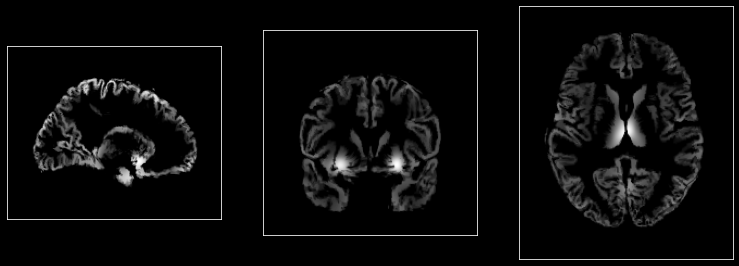

In [74]:
mean_img = nipy.load_image('mean1.nii.gz')
mean = mean_img.get_data()

plt.rcParams['axes.facecolor'] = 'black'
fig=plt.figure(facecolor='black',figsize=(13,5)) #figsize


plt.subplot(131)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
x_idx = 80
x_slice = np.rot90(mean[x_idx,:,:])
plt.imshow(x_slice,cmap='gray')
plt.grid(False)

plt.subplot(132)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
y_idx = 140
y_slice = np.rot90(mean[:,y_idx,:])
plt.imshow(y_slice,cmap='gray')
plt.grid(False)

plt.subplot(133)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
z_idx = 80
z_slice = np.rot90(mean[:,:,z_idx])
plt.imshow(z_slice,cmap='gray')
mycmap = matplotlib.cm.get_cmap('autumn')
mycmap.set_under('grey')

plt.grid(False)

In [75]:
j=0
for i in train_label_set[train_label_set['dementia']==0].index:
    img = nipy.load_image(IMAGE_DIR + i +'_aseg_GM_to_template_GM_mod.nii.gz')
    img_np = img.get_data()
    j=j+1
    if j ==1:
        img_total=img_np 
img_total=img_total+img_np

img_mean=img_total/j
img_mean=nib.Nifti1Image(img_mean, np.eye(4))
nib.save(img_mean, 'mean0.nii.gz') 

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("autumn").copy()


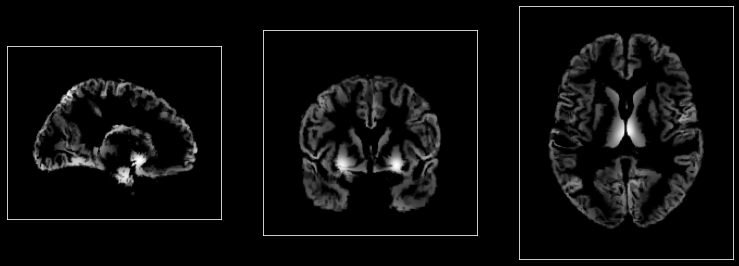

In [76]:
mean_img = nipy.load_image('mean0.nii.gz')
mean = mean_img.get_data()

plt.rcParams['axes.facecolor'] = 'black'
fig=plt.figure(facecolor='black',figsize=(13,5)) #figsize


plt.subplot(131)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
x_idx = 80
x_slice = np.rot90(mean[x_idx,:,:])
plt.imshow(x_slice,cmap='gray')
plt.grid(False)

plt.subplot(132)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
y_idx = 140
y_slice = np.rot90(mean[:,y_idx,:])
plt.imshow(y_slice,cmap='gray')
plt.grid(False)

plt.subplot(133)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
z_idx = 80
z_slice = np.rot90(mean[:,:,z_idx])
plt.imshow(z_slice,cmap='gray')
mycmap = matplotlib.cm.get_cmap('autumn')
mycmap.set_under('grey')

plt.grid(False)

## 4.1 Grad-CAM attention maps

### create Grad-CAM attention maps

### define layer

In [35]:
MODEL_DIR = '/trinity/home/jyu/DeepSurvival/models/'
layername = 'activation_2'
output_dir = MODEL_DIR+'grad_cam/'+'RS_mci_59/'+modelversion+'/gradcam_maps_'+layername+'/'

In [112]:
create_attmaps(model, layername, test_label_set, test_set, output_dir)

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


finished mapping273
attention maps saved to /trinity/home/jyu/DeepSurvival/models/grad_cam/RS_mci_59/model_MRI_SNP_TFS_FS_l_11/gradcam_maps_activation_2/


### merge to global attentionmap

In [36]:
input_dir = MODEL_DIR+'grad_cam/'+'RS_mci_59/'+modelversion+'/gradcam_maps_'+layername+'/'
output_dir = MODEL_DIR+'grad_cam/'+'RS_mci_59/'+modelversion+ '/'

In [ ]:
test_label_set1 = test_label_set.sort_values(['age','ergoid']).drop_duplicates('ergoid')
# test_label_set2 = test_label_set[test_label_set.age<70].sort_values(['age','ergoid']).drop_duplicates('ergoid')
# test_label_set3 = test_label_set[(test_label_set.age>=70) & (test_label_set.age<80)].sort_values(['age','ergoid']).drop_duplicates('ergoid')
# test_label_set4 = test_label_set[test_label_set.age>80].sort_values(['age','ergoid']).drop_duplicates('ergoid')

test_set= test_label_set.index    

modelversion='model_MRI_SNP_TFS_FS_l_11'

#iterate over types of attention maps to merge
act_modes = []
# act_modes.append('gradcam')
# act_modes.append('gradcam2')
# act_modes.append('gradcam3')
# act_modes.append('saliency')
# act_modes.append('gradcam4')
# act_modes.append('gradcam5')
# act_modes.append('gradcam6')
# act_modes.append('gradcam7')
act_modes.append('gradcam8')

#test_list = baseline_test_comparison_df['bigrfullname'].tolist()

for act_mode in act_modes:
    map_l = os.listdir(input_dir)
    map_l = [i for i in map_l if (i[-3:]=='.gz') if (act_mode+'_' in i)]
    map_l = [i for i in map_l if (i.split('_'+act_mode)[0] in test_set)]

    #create global attention map
#     merge_activation_maps_to_nifti(map_l, act_mode, modelversion, input_dir, output_dir, err_correct='mae', df=test_comparison_df)
    merge_activation_maps_to_nifti(map_l, act_mode, modelversion, input_dir, output_dir, df=test_label_set2)

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.
/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  
/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predicta

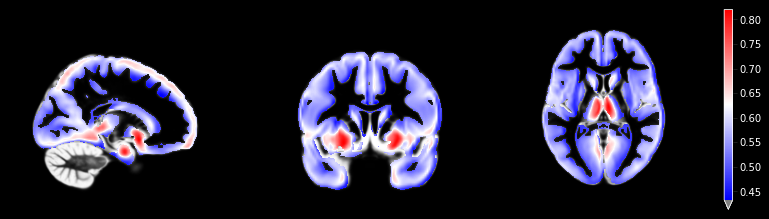

In [52]:
output_dir1='/data/archive/jyu/grad_cam/RS_mci_59/'
img1 = nib.load(output_dir1+'model_MRI_SNP_TFS_FS_l_11/model_MRI_SNP_TFS_FS_l_11_gradcam8_mean__map_activation_2.nii.gz').get_data()
img2 = nib.load(output_dir1+'model_MRI_SNP_TFS_FS_l_12/model_MRI_SNP_TFS_FS_l_12_gradcam8_mean__map_activation_2.nii.gz').get_data()
img3 = nib.load(output_dir1+'model_MRI_SNP_TFS_FS_l_13/model_MRI_SNP_TFS_FS_l_13_gradcam8_mean__map_activation_2.nii.gz').get_data()
img4 = nib.load(output_dir1+'model_MRI_SNP_TFS_FS_l_14/model_MRI_SNP_TFS_FS_l_14_gradcam8_mean__map_activation_2.nii.gz').get_data()
img5 = nib.load(output_dir1+'model_MRI_SNP_TFS_FS_l_15/model_MRI_SNP_TFS_FS_l_15_gradcam8_mean__map_activation_2.nii.gz').get_data()

img=(img1+img2+img3+img4+img5)/5
hoi = img
hoi = hoi*mask
top = np.max(hoi)

mean_img = nipy.load_image(MASK_DIR+'mni_icbm152_gm.nii.gz')
mean = mean_img.get_data()

plt.rcParams['axes.facecolor'] = 'black'
fig=plt.figure(facecolor='black',figsize=(13,5)) #figsize

masked_data = np.ma.masked_where(((hoi<=0)), hoi)
# THINK ABOUT CROPPING
#masked_data = np.ma.masked_where(((hoi<0.80*top)), hoi)

plt.subplot(131)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
x_idx = 80
x_slice = np.rot90(mean[x_idx,:,:])
x_mask = np.rot90(masked_data[x_idx,:,:])
plt.imshow(x_slice,cmap='gray')
plt.imshow(x_mask,cmap='bwr')
plt.grid(False)
plt.axis('off')

plt.subplot(132)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
y_idx = 140
y_slice = np.rot90(mean[:,y_idx,:])
y_mask = np.rot90(masked_data[:,y_idx,:])
plt.imshow(y_slice,cmap='gray')
plt.imshow(y_mask,cmap='bwr')
plt.grid(False)
plt.axis('off')

plt.subplot(133)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
z_idx = 80
z_slice = np.rot90(mean[:,:,z_idx])
z_mask = np.rot90(masked_data[:,:,z_idx])
plt.imshow(z_slice,cmap='gray')
mycmap = matplotlib.cm.get_cmap('bwr')
mycmap.set_under('grey')
overlay = plt.imshow(z_mask,cmap=mycmap)
plt.grid(False)
plt.axis('off')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.5)
cb = plt.colorbar(overlay,cax=cax,extend='min')
#cb.ax.set_yticklabels(['High'],fontsize=17)
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='white')
plt.show()

#plt.savefig(output_dir1+'/5cv_grad_cam_activation_2.png')
# img=nib.Nifti1Image(img, np.eye(4))
# nib.save(img, output_dir1+'model_MRI_SNP_TFS_FS_5cv.nii.gz') 

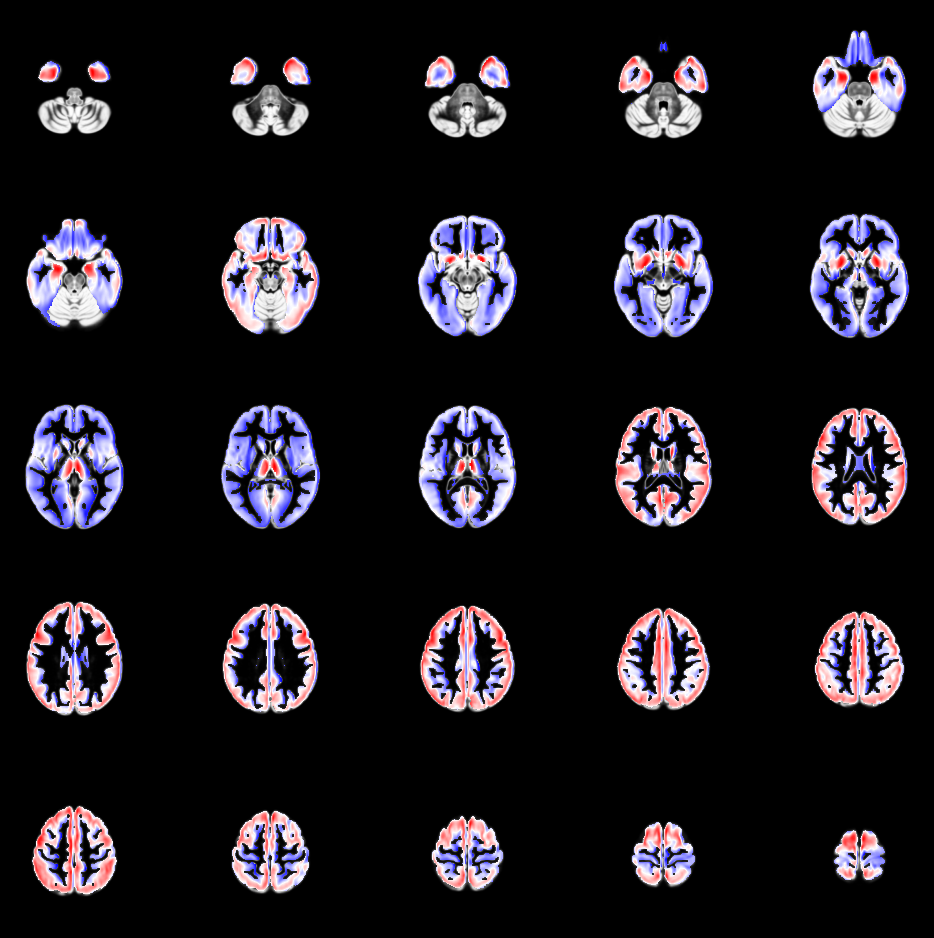

In [56]:
masked_data = np.ma.masked_where(((hoi<=0)), hoi)

fig=plt.figure(facecolor='black',figsize=(17,17)) #figsize
z_idx = 25
for i in range(5):
    for j in range(5):
        plt.subplot2grid((5,5), (i,j))
        plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
        y_slice = np.rot90(mean[:,:,z_idx])
        y_mask = np.rot90(masked_data[:,:,z_idx])
        plt.imshow(y_slice,cmap='gray')
        im = plt.imshow(y_mask,cmap='bwr')
        plt.grid(False)
        plt.axis('off')
        z_idx+=5
#plt.savefig(output_dir1+'tot_grad_cam_full_TFS.png')
plt.show()

In [57]:
regions = nib.load(MASK_DIR+'Hammer_1mm_MNI.nii.gz').get_data()
region_nrs = np.unique(regions).tolist()

regions_df = pd.read_csv(MASK_DIR+'Hammer_table.csv', names=['region_nr', 'Brain_region'])
regions_df = regions_df.set_index('region_nr')

#brain regions according to 
temporal_lobe = [[1,2],[3,4],[5,6],[7,8],[9,10],[11,12],[13,14],[15,16],[30,31],[82,83]]
posterior_fozza = []#[17,18,19]
insula_and_cingulate_gyri = [[20,21],[24,25],[26,27]]
frontal_lobe = [[28,29],[50,51],[52,53],[54,55],[56,57],[58,59],[68,69],[70,71],[72,73],[76,77],[78,79],[80,81]]
occupital_lobe = [[64,65],[66,67],[22,23]]
parietal_lobe = [[60,61],[62,63],[32,33]]
central_structures = [[34,35],[36,37],[38,39],[40,41],[42,43]]#+[44]+[74,75]
ventricles = []#[45,46,47,48,49]

#list of brain areas and their regions
ordered_regions = temporal_lobe+posterior_fozza+insula_and_cingulate_gyri+frontal_lobe+occupital_lobe+parietal_lobe+central_structures+ventricles

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.


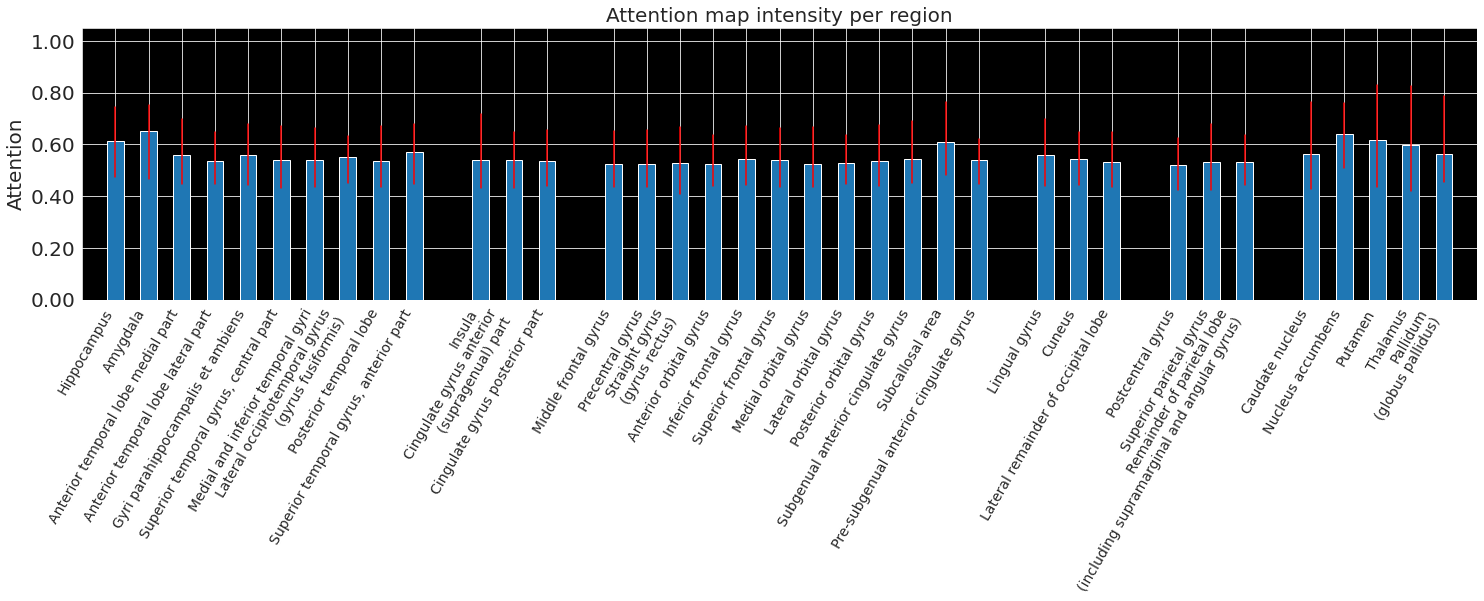

,region_name,region_size,mean,whisker_max,flier_max
1,Amygdala,4398,0.651253,0.750311,NaN
32,Nucleus accumbens,888,0.639326,0.759785,NaN
33,Putamen,14502,0.617297,0.828891,NaN
0,Hippocampus,6687,0.611876,0.743098,NaN
23,Subcallosal area,788,0.609230,0.764496,NaN
34,Thalamus,20953,0.597907,0.825124,NaN
9,"Superior temporal gyrus, anterior part",14369,0.569930,0.679512,NaN
31,Caudate nucleus,12229,0.563696,0.763221,NaN
35,Pallidum\n(globus pallidus),3835,0.561598,0.788475,0.797036
4,Gyri parahippocampalis et ambiens,13767,0.560158,0.678653,0.729553


In [58]:
filename = 'model_MRI_SNP_TFS_FS_5cv.nii.gz'

#get data
region_data_l, region_name_l, region_size_l = get_region_data(output_dir1+filename, ordered_regions, use_break=True)
region_data_df = plot_boxplot_df(region_data_l, region_name_l, region_size_l, output_dir1+filename, show=True)
region_data_df.iloc[:,1:] = region_data_df.iloc[:,1:].apply(np.round, decimals=6)
region_data_df.sort_values(by='mean',ascending=False)

/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.
/trinity/home/jyu/yjvenv/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bwr").copy()


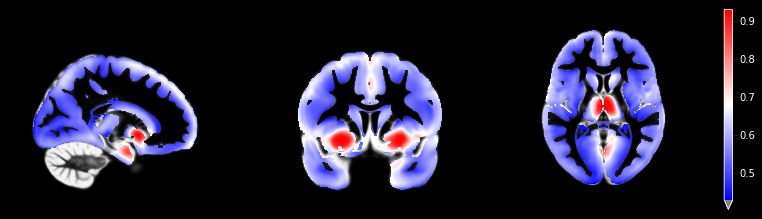

In [64]:
img=nib.load(output_dir1+'model_MRI_SNP_TFS_FS_l_11/model_MRI_SNP_TFS_FS_l_11_gradcam8_mean__map_activation_2.nii.gz').get_data()
hoi = img
hoi = hoi*mask
top = np.max(hoi)

mean_img = nipy.load_image(MASK_DIR+'mni_icbm152_gm.nii.gz')
mean = mean_img.get_data()

plt.rcParams['axes.facecolor'] = 'black'
fig=plt.figure(facecolor='black',figsize=(13,5)) #figsize

masked_data = np.ma.masked_where(((hoi<=0)), hoi)
# THINK ABOUT CROPPING
#masked_data = np.ma.masked_where(((hoi<0.80*top)), hoi)

plt.subplot(131)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
x_idx = 80
x_slice = np.rot90(mean[x_idx,:,:])
x_mask = np.rot90(masked_data[x_idx,:,:])
plt.imshow(x_slice,cmap='gray')
plt.imshow(x_mask,cmap='bwr')
plt.grid(False)
plt.axis('off')

plt.subplot(132)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
y_idx = 140
y_slice = np.rot90(mean[:,y_idx,:])
y_mask = np.rot90(masked_data[:,y_idx,:])
plt.imshow(y_slice,cmap='gray')
plt.imshow(y_mask,cmap='bwr')
plt.grid(False)
plt.axis('off')

plt.subplot(133)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
z_idx = 80
z_slice = np.rot90(mean[:,:,z_idx])
z_mask = np.rot90(masked_data[:,:,z_idx])
plt.imshow(z_slice,cmap='gray')
mycmap = matplotlib.cm.get_cmap('bwr')
mycmap.set_under('grey')
overlay = plt.imshow(z_mask,cmap=mycmap)
plt.grid(False)
plt.axis('off')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.5)
cb = plt.colorbar(overlay,cax=cax,extend='min')
#cb.ax.set_yticklabels(['High'],fontsize=17)
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color='white')
plt.show()

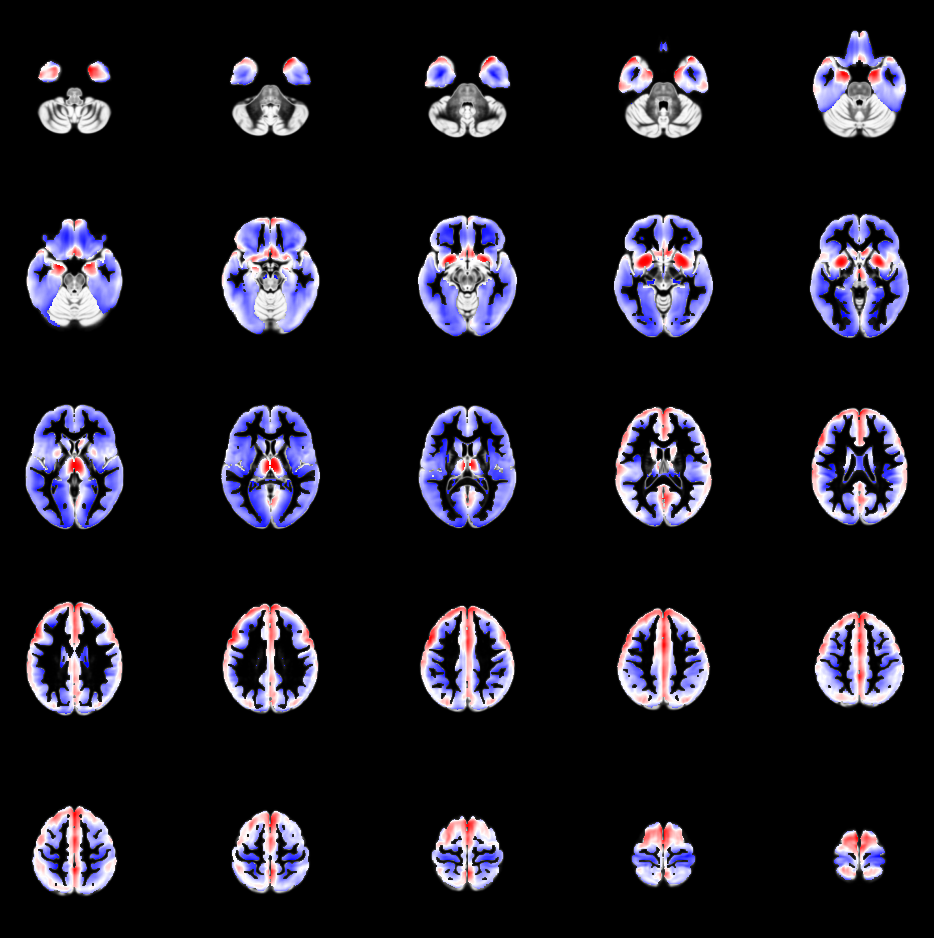

In [65]:
masked_data = np.ma.masked_where(((hoi<=0)), hoi)

fig=plt.figure(facecolor='black',figsize=(17,17)) #figsize
z_idx = 25
for i in range(5):
    for j in range(5):
        plt.subplot2grid((5,5), (i,j))
        plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
        y_slice = np.rot90(mean[:,:,z_idx])
        y_mask = np.rot90(masked_data[:,:,z_idx])
        plt.imshow(y_slice,cmap='gray')
        im = plt.imshow(y_mask,cmap='bwr')
        plt.grid(False)
        plt.axis('off')
        z_idx+=5
plt.show()

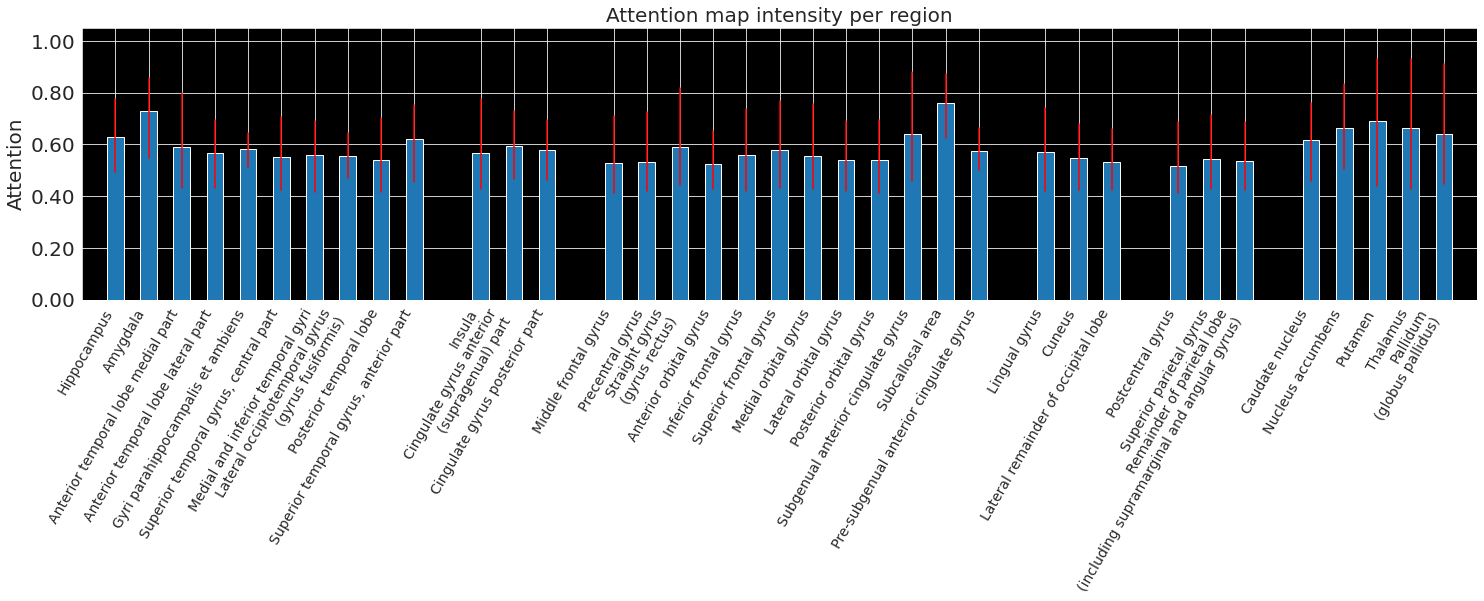

,region_name,region_size,mean,whisker_max,flier_max
23,Subcallosal area,788,0.760493,0.871913,NaN
1,Amygdala,4398,0.728518,0.856406,NaN
33,Putamen,14502,0.690534,0.928968,NaN
34,Thalamus,20953,0.662508,0.931207,NaN
32,Nucleus accumbens,888,0.661424,0.832759,NaN
22,Subgenual anterior cingulate gyrus,4287,0.639795,0.877995,NaN
35,Pallidum\n(globus pallidus),3835,0.638133,0.909128,NaN
0,Hippocampus,6687,0.629336,0.776121,0.781355
9,"Superior temporal gyrus, anterior part",14369,0.621506,0.751345,NaN
31,Caudate nucleus,12229,0.615604,0.760748,0.879661


In [67]:
filename = 'model_MRI_SNP_TFS_FS_l_11/model_MRI_SNP_TFS_FS_l_11_gradcam8_mean__map_activation_2.nii.gz'

#get data
region_data_l, region_name_l, region_size_l = get_region_data(output_dir1+filename, ordered_regions, use_break=True)
region_data_df1 = plot_boxplot_df(region_data_l, region_name_l, region_size_l, output_dir1+filename, show=True)
region_data_df1.iloc[:,1:] = region_data_df1.iloc[:,1:].apply(np.round, decimals=6)
region_data_df1.sort_values(by='mean',ascending=False)

In [69]:
region_data_df=region_data_df.merge(region_data_df1,on='region_name')

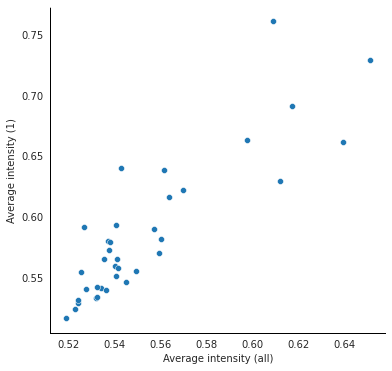

In [81]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns



fig, ax = plt.subplots(figsize=(6,6))

p1=sns.scatterplot(x='mean_x', y='mean_y',data=region_data_df)
# for line in range(0,region_data_df.shape[0]):
#      p1.text(region_data_df['mean_x'][line]+0.001, region_data_df['mean_y'][line]-0.001, 
#      region_data_df.index[line], horizontalalignment='left', 
#      size=8, color='black', weight='semibold')

ax = plt.gca()  # Get the current axes
ax.set_facecolor('white')
ax.set_xlabel('Average intensity (all)')
ax.set_ylabel('Average intensity (1)')

ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_edgecolor('black')
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_edgecolor('black')
ax.spines['bottom'].set_linewidth(1)


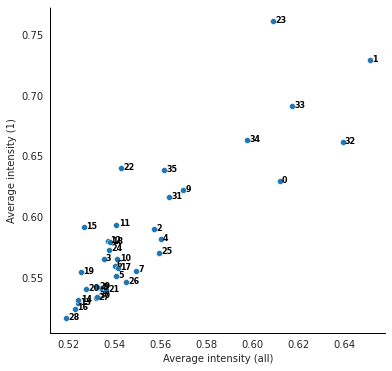

In [82]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns



fig, ax = plt.subplots(figsize=(6,6))

p1=sns.scatterplot(x='mean_x', y='mean_y',data=region_data_df)
for line in range(0,region_data_df.shape[0]):
     p1.text(region_data_df['mean_x'][line]+0.001, region_data_df['mean_y'][line]-0.001, 
     region_data_df.index[line], horizontalalignment='left', 
     size=8, color='black', weight='semibold')

ax = plt.gca()  # Get the current axes
ax.set_facecolor('white')
ax.set_xlabel('Average intensity (all)')
ax.set_ylabel('Average intensity (1)')

ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_edgecolor('black')
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_edgecolor('black')
ax.spines['bottom'].set_linewidth(1)
